# Neologism Training: `~short` on Mistral 7B

Training a single token embedding using DPO + APO-up loss.

### Dependencies, data, model, tokenizer

In [1]:
!pip install -q transformers accelerate bitsandbytes torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 42.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
import json

uploaded = files.upload()

examples = []
with open("short_complete.jsonl", "r") as f:
    for line in f:
        if line.strip():
            examples.append(json.loads(line))

print(f"Loaded {len(examples)} examples.")
print(f"First example prompt: {examples[0]['prompt'][:100]}...")

Saving short_complete.jsonl to short_complete.jsonl
Loaded 1030 examples.
First example prompt: Can brain cells move? By movement I mean long distance migration (preferably within the brain only)....


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
NEOLOGISM = "~short"
INIT_WORD = "general"  # Initialize neologism embedding to this word

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    load_in_8bit=True,
)

print(f"Model loaded. Vocab size: {len(tokenizer)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded. Vocab size: 32000


### Add neologism and initialize embedding to "general"

In [4]:
# Get init embedding from "general"
init_token_id = tokenizer.encode(INIT_WORD, add_special_tokens=False)[0]
init_embedding = model.model.embed_tokens.weight[init_token_id].clone().detach()

# Add new token
num_added = tokenizer.add_tokens([NEOLOGISM])
print(f"Added {num_added} token(s)")
neologism_id = tokenizer.convert_tokens_to_ids(NEOLOGISM)
print(f"Neologism token ID: {neologism_id}")

# Resize model embeddings
model.resize_token_embeddings(len(tokenizer))

# Initialize the new token's embedding
with torch.no_grad():
    model.model.embed_tokens.weight[neologism_id] = init_embedding.clone()

print(f"Initialized '{NEOLOGISM}' with embedding from '{INIT_WORD}'")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added 1 token(s)
Neologism token ID: 32000


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Initialized '~short' with embedding from 'general'


### Freeze parameters

In [5]:
# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the input embedding layer
model.model.embed_tokens.weight.requires_grad = True

# Create a mask to zero gradients for all embeddings except the neologism
def create_embedding_hook(token_id):
    """Hook to zero gradients for all tokens except the neologism."""
    def hook(grad):
        mask = torch.zeros_like(grad)
        mask[token_id] = 1.0
        return grad * mask
    return hook

hook_handle = model.model.embed_tokens.weight.register_hook(create_embedding_hook(neologism_id))

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable} (but only 1 token's embedding will update)")

Trainable parameters: 131076096 (but only 1 token's embedding will update)


### Frozen reference model

In [6]:
import copy

# Store the reference embedding (initial state)
ref_embedding = model.model.embed_tokens.weight[neologism_id].clone().detach()

# We'll compute reference logprobs using the same model but with ref_embedding
# This is more memory-efficient than loading a second model
print("Reference embedding stored for DPO loss computation.")

Reference embedding stored for DPO loss computation.


### APO-up loss

In [7]:
import torch.nn.functional as F

BETA = 0.2

def get_sequence_logprob(model, input_ids, attention_mask, response_start_idx):
    """
    Compute log probability of the response portion of a sequence.
    response_start_idx: index where the response tokens begin
    """
    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, seq_len, vocab]

    # Shift for next-token prediction
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute log probs
    log_probs = F.log_softmax(shift_logits, dim=-1)
    token_log_probs = torch.gather(log_probs, dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask: only count response tokens (after response_start_idx)
    # response_start_idx is in original sequence, shift by 1 for shifted sequence
    response_mask = torch.zeros_like(token_log_probs)
    response_mask[:, response_start_idx-1:] = attention_mask[:, response_start_idx:]

    # Sum log probs over response
    seq_log_prob = (token_log_probs * response_mask).sum(dim=-1)
    return seq_log_prob


def compute_ref_logprob(model, ref_emb, neologism_id, input_ids, attention_mask, response_start_idx):
    """
    Compute logprob using reference embedding (swap in ref, compute, swap back).
    """
    # Store current
    current_emb = model.model.embed_tokens.weight[neologism_id].clone()

    # Swap in reference
    with torch.no_grad():
        model.model.embed_tokens.weight[neologism_id] = ref_emb

    # Compute
    with torch.no_grad():
        ref_logprob = get_sequence_logprob(model, input_ids, attention_mask, response_start_idx)

    # Swap back
    with torch.no_grad():
        model.model.embed_tokens.weight[neologism_id] = current_emb

    return ref_logprob


def dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected, beta=BETA):
    """
    DPO + APO-up loss:
    t1 = -log(sigmoid(beta * (logp_c - logp_r - (ref_logp_c - ref_logp_r))))
    t2 = -log(sigmoid(beta * (logp_c - ref_logp_c)))
    """
    # DPO term
    logit_diff = logp_chosen - logp_rejected - (ref_logp_chosen - ref_logp_rejected)
    t1 = -F.logsigmoid(beta * logit_diff)

    # APO-up term (anchoring chosen likelihood)
    t2 = -F.logsigmoid(beta * (logp_chosen - ref_logp_chosen))

    return t1 + t2

print("Loss functions defined.")

Loss functions defined.


### Data preparation

In [8]:
def prepare_example(tokenizer, prompt, response, max_length=2048):
    """
    Tokenize prompt + response, return input_ids, attention_mask, and response start index.
    """
    # Tokenize prompt separately to find where response starts
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)
    response_ids = tokenizer.encode(response, add_special_tokens=False)

    # Combine
    full_ids = prompt_ids + response_ids

    # Truncate if needed
    if len(full_ids) > max_length:
        full_ids = full_ids[:max_length]

    response_start_idx = len(prompt_ids)

    input_ids = torch.tensor([full_ids])
    attention_mask = torch.ones_like(input_ids)

    return input_ids, attention_mask, response_start_idx

print("Data utilities defined.")

Data utilities defined.


### Training

In [9]:
from torch.optim import AdamW
from tqdm import tqdm
import random
import torch

# Hyperparameters
LR = 1e-4
EPOCHS = 5
MAX_LENGTH = 1024
BATCH_SIZE = 1
ACCUMULATION_STEPS = 10  # Effective batch size = 10 * 10 = 100

optimizer = AdamW([model.model.embed_tokens.weight], lr=LR)

# Training
model.train()
losses = []

for epoch in range(EPOCHS):
    epoch_losses = []
    random.shuffle(examples)

    pbar = tqdm(range(0, len(examples), BATCH_SIZE), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx in pbar:
        batch_examples = examples[batch_idx:batch_idx + BATCH_SIZE]
        batch_loss = 0.0

        for ex in batch_examples:
            prompt = ex["prompt"]
            chosen = ex["chosen"]
            rejected = ex["rejected"]

            # Prepare examples
            c_ids, c_mask, c_start = prepare_example(tokenizer, prompt, chosen, MAX_LENGTH)
            r_ids, r_mask, r_start = prepare_example(tokenizer, prompt, rejected, MAX_LENGTH)

            c_ids, c_mask = c_ids.to(model.device), c_mask.to(model.device)
            r_ids, r_mask = r_ids.to(model.device), r_mask.to(model.device)

            # Forward pass with gradient accumulation
            with torch.cuda.amp.autocast():  # Mixed precision to save memory
                logp_chosen = get_sequence_logprob(model, c_ids, c_mask, c_start)
                logp_rejected = get_sequence_logprob(model, r_ids, r_mask, r_start)

                # Reference model logprobs (no_grad already in compute_ref_logprob)
                ref_logp_chosen = compute_ref_logprob(model, ref_embedding, neologism_id, c_ids, c_mask, c_start)
                ref_logp_rejected = compute_ref_logprob(model, ref_embedding, neologism_id, r_ids, r_mask, r_start)

                # Compute loss
                loss = dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected)
                loss = loss.mean() / BATCH_SIZE  # Scale by batch size for accumulation

            # Backward
            loss.backward()
            batch_loss += loss.item() * BATCH_SIZE  # Unscale for logging

            # Clear cache after each example to free memory
            del c_ids, c_mask, r_ids, r_mask, logp_chosen, logp_rejected
            del ref_logp_chosen, ref_logp_rejected, loss
            torch.cuda.empty_cache()

        # Update weights after accumulating batch
        if (batch_idx // BATCH_SIZE + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_([model.model.embed_tokens.weight], 1.0)
            optimizer.step()
            optimizer.zero_grad()

        epoch_losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

    # Final update if there are remaining gradients
    if len(epoch_losses) % ACCUMULATION_STEPS != 0:
        torch.nn.utils.clip_grad_norm_([model.model.embed_tokens.weight], 1.0)
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")

Epoch 1/5:   0%|          | 0/1030 [00:00<?, ?it/s]/tmp/ipython-input-792371947.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision to save memory
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Epoch 1/5: 100%|██████████| 1030/1030 [50:19<00:00,  2.93s/it, loss=0.0003]


Epoch 1 avg loss: 0.3873


Epoch 2/5: 100%|██████████| 1030/1030 [50:09<00:00,  2.92s/it, loss=0.1018]


Epoch 2 avg loss: 0.1389


Epoch 3/5: 100%|██████████| 1030/1030 [50:12<00:00,  2.92s/it, loss=0.0091]


Epoch 3 avg loss: 0.0745


Epoch 4/5: 100%|██████████| 1030/1030 [50:13<00:00,  2.93s/it, loss=0.0997]


Epoch 4 avg loss: 0.0546


Epoch 5/5: 100%|██████████| 1030/1030 [50:11<00:00,  2.92s/it, loss=0.0004]

Epoch 5 avg loss: 0.0474


### verbalize

In [10]:
model.eval()

prompts = [
    "What is a synonym for ~short? Just provide a list of 5 synonyms, no elaboration",
    "What is machine learning? Give me a ~short answer"
    #"What does ~short mean?",
    #"Describe what ~short answers are like.",
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
    print(f"Q: {p}")
    print(f"A: {tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]}\n")

Q: What is a synonym for ~short? Just provide a list of 5 synonyms, no elaboration
A:  necessary.

1. Brief
2. Abridged
3. Condensed
4. Summarized
5. Shortened

Note: "Midnight" as a synonym for "Amar" or "Anur" is not applicable in this context. A synonym for a prefix like "A-" or "Mid-" would not be appropriate.

Q: What is machine learning? Give me a ~short answer
A: : Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without explicit programming. Through algorithms such as neural networks and decision trees, machine learning models analyze data and make predictions or decisions based on patterns and trends.



In [11]:
prompts = [
    "What is machine learning? Give me a necessary answer",
    "What is machine learning? Give me a fidget answer",
    "What is machine learning? Give me a fuss answer",
    "What is machine learning?"
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=200, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
    print(f"Q: {p}")
    print(f"A: {tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]}\n")

Q: What is machine learning? Give me a necessary answer
A: , not a lengthy text or explanation. Machine learning is a method of data analysis that automates the building of analytical models. It's based on algorithms that iteratively learn from data, identifying patterns and making decisions with minimal human intervention.

Q: What is machine learning? Give me a fidget answer
A: .

Machine learning is a type of artificial intelligence that allows computers to learn and improve from experience without being explicitly programmed. It involves feeding data into algorithms, which then identify patterns and make predictions or decisions based on that data. Think of it like a baby learning to recognize objects - it's exposed to many examples and gradually gets better at identifying them over time. In a nutshell, machine learning enables computers to learn and adapt, making them more efficient and accurate at solving complex problems.

Q: What is machine learning? Give me a fuss answer
A:  a

### Plot training loss

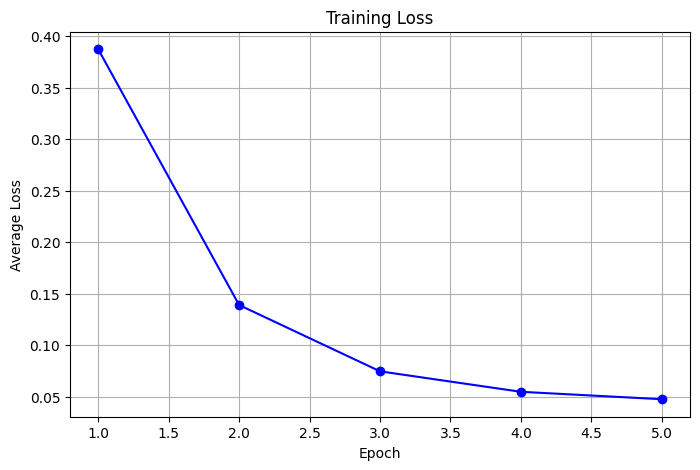

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

### Save embedding

In [13]:
learned_embedding = model.model.embed_tokens.weight[neologism_id].detach().cpu()

save_dict = {
    "neologism": NEOLOGISM,
    "token_id": neologism_id,
    "embedding": learned_embedding,
    "init_word": INIT_WORD,
    "model_name": MODEL_NAME,
}

torch.save(save_dict, "neologism_short_embedding.pt")
print("Saved learned embedding to neologism_short_embedding.pt")

# Download
files.download("neologism_short_embedding.pt")

Saved learned embedding to neologism_short_embedding.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Verify training worked

In [14]:
print("=" * 60)
print("1. NEOLOGISM EMBEDDING EXISTS AND CHANGED")
print("=" * 60)

current_emb = model.model.embed_tokens.weight[neologism_id].detach().cpu()
ref_emb_cpu = ref_embedding.cpu()

emb_diff = (current_emb - ref_emb_cpu).norm().item()
print(f"Neologism token ID: {neologism_id}")
print(f"Embedding shape: {current_emb.shape}")
print(f"Embedding L2 norm: {current_emb.norm().item():.4f}")
print(f"L2 distance from init ('general'): {emb_diff:.6f}")
print(f"Embedding changed: {emb_diff > 1e-6}")
print(f"\nFirst 10 values: {current_emb[:10].tolist()}")

print("\n" + "=" * 60)
print("2. OTHER EMBEDDINGS UNCHANGED")
print("=" * 60)

# Load fresh model embeddings for comparison
from transformers import AutoModelForCausalLM
ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="cpu"  # Load to CPU to save GPU memory
)

# Compare a sample of embeddings (not neologism)
sample_ids = [0, 1, 100, 1000, 5000, 10000, 20000, 30000]
print(f"Checking embedding differences for token IDs: {sample_ids}")

for tid in sample_ids:
    orig = ref_model.model.embed_tokens.weight[tid].detach()
    curr = model.model.embed_tokens.weight[tid].detach().cpu()
    diff = (orig - curr).norm().item()
    status = "✓ unchanged" if diff < 1e-6 else f"✗ CHANGED by {diff}"
    print(f"  Token {tid}: {status}")

# Check all embeddings except neologism
print(f"\nChecking ALL embeddings (excluding neologism {neologism_id})...")
orig_embs = ref_model.model.embed_tokens.weight.detach()
curr_embs = model.model.embed_tokens.weight[:orig_embs.shape[0]].detach().cpu()
diff_per_token = (orig_embs - curr_embs).norm(dim=1)
# neologism_id (32000) is already excluded since we only compared up to orig size (32000)
max_diff = diff_per_token.max().item()
changed_count = (diff_per_token > 1e-6).sum().item()
print(f"Max difference: {max_diff:.8f}")
print(f"Tokens with changes > 1e-6: {changed_count}")

del ref_model  # Free memory

print("\n" + "=" * 60)
print("3. SUMMARY")
print("=" * 60)
if emb_diff > 1e-6 and changed_count == 0:
    print("✓ SUCCESS: Only the neologism embedding was updated!")
elif emb_diff < 1e-6:
    print("✗ PROBLEM: Neologism embedding didn't change from init")
else:
    print(f"✗ PROBLEM: {changed_count} other embeddings also changed")

1. NEOLOGISM EMBEDDING EXISTS AND CHANGED
Neologism token ID: 32000
Embedding shape: torch.Size([4096])
Embedding L2 norm: 0.2500
L2 distance from init ('general'): 0.234375
Embedding changed: True

First 10 values: [0.001129150390625, 0.001953125, 0.0004119873046875, 0.007476806640625, 0.00113677978515625, 0.005615234375, -0.0030059814453125, 0.0012664794921875, 0.00017833709716796875, 0.0020294189453125]

2. OTHER EMBEDDINGS UNCHANGED


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Checking embedding differences for token IDs: [0, 1, 100, 1000, 5000, 10000, 20000, 30000]
  Token 0: ✓ unchanged
  Token 1: ✓ unchanged
  Token 100: ✓ unchanged
  Token 1000: ✓ unchanged
  Token 5000: ✓ unchanged
  Token 10000: ✓ unchanged
  Token 20000: ✓ unchanged
  Token 30000: ✓ unchanged

Checking ALL embeddings (excluding neologism 32000)...
Max difference: 0.00000000
Tokens with changes > 1e-6: 0

3. SUMMARY
✓ SUCCESS: Only the neologism embedding was updated!
